In [1]:
#performs frequency encoding
#converting _encd to _freq
#compare to a base model
#should use the same Model.csv files as in v2 
import pandas as pd
import numpy as np

In [2]:
#data
dataset = pd.read_csv('/home/kate/data/ClaimPrediction/fdata_v1_encd.csv', index_col=None)
target_column = 'hasclaim'

In [3]:
#models and analyzing results directory
ModelsDir='/home/kate/data/ClaimPrediction/fe5_freqencoding/'

In [4]:
#comparing model metrics with t-test
#and save results
import scipy.stats as stats
def AnalyzeAndSaveModelsResults(result_df,result_lst,ModelName,filename):
    df=pd.DataFrame([result_lst])
    TestSizeColumns=['S0.45','S0.4','S0.35','S0.3','S0.25','S0.2','S0.15','S0.1']
    #TestSizeColumns=['S0.2','S0.15','S0.1']
    df.columns=['Model']+TestSizeColumns
    #mean
    df['Mean'] = df.drop('Model', axis=1).mean(axis=1)
    df['t-pvalue'] = 1
    df['t-statistic'] = 0
    df['Group'] = 1
    #t-test with base model
    if ModelName!='BaseModel':
        base_model=result_df[result_df['Model'] == 'BaseModel'].iloc[0]
        current_model=df.iloc[0]
        t=stats.ttest_ind(base_model[TestSizeColumns].tolist(),current_model[TestSizeColumns].tolist())
        line_to_save=[current_model['Model']]
        line_to_save.extend(current_model[TestSizeColumns].tolist())
        line_to_save.append(current_model[TestSizeColumns].mean())
        line_to_save.append(t.pvalue)
        line_to_save.append(t.statistic)
        if ((t.pvalue<=0.05) and (base_model['Mean']<current_model['Mean'])):
            line_to_save.append(2)
        elif ((t.pvalue<=0.05) and (base_model['Mean']>current_model['Mean'])):
            line_to_save.append(3)    
        else:
            line_to_save.append(1)                  
        df_to_save=pd.DataFrame([line_to_save])
        df_to_save.columns=['Model']+TestSizeColumns+['Mean','t-pvalue','t-statistic','Group']
        result_df=result_df.append(df_to_save, ignore_index=True)
    else:
        result_df=result_df.append(df, ignore_index=True)
    result_df.to_csv(ModelsDir+filename, index = False)
    return result_df

In [5]:
# This function performs frequency encoding
# and return encoded column for train dataset
def freq_encoding(col_name, train_col):
    col_name_freq=col_name.replace('_encd','')+'_freq'
    freq=train_col.value_counts()
    freq=pd.DataFrame(freq)
    freq.reset_index(inplace=True)
    freq.columns=[[col_name,col_name_freq]]
    
    return freq

In [6]:
#xgb library and parameters to tune later
import xgboost as xgb
xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'silent': True,
        'booster': 'gbtree',
        'seed': 42,
        'scale_pos_weight':0.3,
        'colsample_bylevel': 0.232094506,
        'colsample_bytree': 0.978684648,
        'eta': 0.01208041,
        'max_depth': 4}

In [7]:
#Evaluation metric to be used in tuning
from sklearn.metrics import roc_auc_score
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

In [8]:
#StratifiedKFold
from sklearn.model_selection import StratifiedKFold
nrounds=5000 # need to change to 2000
kfold = 10  # need to change to 10
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [9]:
#splitting to train/test in the loop below
from sklearn.model_selection import train_test_split

In [10]:
#each line in the file contains the model name and set of features to analize
models = pd.read_csv(ModelsDir+'Models.csv', index_col=None)

In [11]:
#summary for test and train metrics for each model to test overfitting
models_test_gini_df=pd.DataFrame()
models_test_roc_auc_df=pd.DataFrame()
#
models_train_gini_df=pd.DataFrame()
models_train_roc_auc_df=pd.DataFrame()

In [13]:
for index, row in models.iterrows():
    #for test and train metrics for each model to test overfitting
    gini_test_lst=[]
    roc_auc_test_lst=[]
    gini_train_lst=[]
    roc_auc_train_lst=[]
    #Starting analyzing metric
    print (index, ': Analyzing model %s'%row['Model'])
    gini_test_lst.append(row['Model'])
    roc_auc_test_lst.append(row['Model'])
    gini_train_lst.append(row['Model'])
    roc_auc_train_lst.append(row['Model'])
    featureset=row[1:51].tolist()
    featureset=[x for x in featureset if str(x) != 'nan']
    print(featureset)
    #calculating metrics for the current featureset and 
    #several data sizes
    for s in (0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1):
        print ('Test size %s'%s)
        X, X_test, y, y_test = train_test_split(dataset.loc[:,featureset], dataset[target_column], test_size=s, random_state=42)
        #prediction dataframes
        y_pred_test=pd.DataFrame(index=y_test.index)
        y_pred_test[target_column]=0
        #
        X_test_origin=X_test.copy(deep=True)
        #Stratified Fold
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            print(' xgb kfold: {}  of  {} : '.format(i+1, kfold))
            #getting fold data
            X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
            #adding frequency encoding to train set
            #for each train, test and valid part _encd columns
            X_test=X_test_origin.copy(deep=True)
            for c in X_train.columns[X_train.columns.to_series().str.contains('_encd')]:
                print('------------------------')
                print(c)
                print('------------------------')
                freq_df=freq_encoding(c, X_train[c])
                X_train=pd.merge(X_train, freq_df, how='left', on=c)
                X_train.drop(c, axis=1, inplace=True)
                #valid
                X_valid=pd.merge(X_valid, freq_df, how='left', on=c)
                # if certain levels in the valid dataset is not observed in the train dataset, 
                # we assign frequency of zero to them
                X_valid.fillna(0, inplace=True)
                X_valid[c.replace('_encd','')+'_freq']=X_valid[c.replace('_encd','')+'_freq'].astype(np.int32)
                X_valid.drop(c, axis=1, inplace=True)
                #test
                X_test=pd.merge(X_test, freq_df, how='left', on=c)
                # if certain levels in the test dataset is not observed in the train dataset, 
                # we assign frequency of zero to them
                X_test.fillna(0, inplace=True)
                X_test[c.replace('_encd','')+'_freq']=X_test[c.replace('_encd','')+'_freq'].astype(np.int32)
                X_test.drop(c, axis=1, inplace=True)
            #
            X_train = X_train.values
            X_valid = X_valid.values
            #
            y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
            #
            y_pred_train=pd.DataFrame(index=y_train.index)
            y_pred_train[target_column]=0
            #
            y_train = y_train.values
            y_valid = y_valid.values
            #applying XGB
            d_train = xgb.DMatrix(X_train, y_train) 
            d_valid = xgb.DMatrix(X_valid, y_valid) 
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            xgb_model = xgb.train(xgb_params, d_train, nrounds, watchlist, early_stopping_rounds=100, 
                          feval=gini_xgb, maximize=True, verbose_eval=1000)
            y_pred_test[target_column] +=  xgb_model.predict(xgb.DMatrix(X_test.values), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
            y_pred_train[target_column] += xgb_model.predict(xgb.DMatrix(X_train), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
        #Prediction results
        #test
        g=gini(y_test,y_pred_test)/gini(y_test,y_test)
        print('Test Gini - %f'%g)
        gini_test_lst.append(g)
        ROC_AUC=roc_auc_score(y_test, y_pred_test)
        print('Test ROC_AUC - %f'%ROC_AUC)
        roc_auc_test_lst.append(ROC_AUC)
        #train
        g=gini(y_train,y_pred_train)/gini(y_train,y_train)
        print('Train Gini - %f'%g)
        gini_train_lst.append(g)
        ROC_AUC=roc_auc_score(y_train, y_pred_train)
        print('Train ROC_AUC - %f'%ROC_AUC)
        roc_auc_train_lst.append(ROC_AUC)
    #save model analysis results
    models_test_gini_df=AnalyzeAndSaveModelsResults(models_test_gini_df,gini_test_lst,row['Model'],'models_test_gini.csv')
    models_test_roc_auc_df=AnalyzeAndSaveModelsResults(models_test_roc_auc_df,roc_auc_test_lst,row['Model'],'models_test_roc_auc.csv')
    models_train_gini_df=AnalyzeAndSaveModelsResults(models_train_gini_df,gini_train_lst,row['Model'],'models_train_gini.csv')
    models_train_roc_auc_df=AnalyzeAndSaveModelsResults(models_train_roc_auc_df,roc_auc_train_lst,row['Model'],'models_train_roc_auc.csv')

0 : Analyzing model BaseModel
['driverage', 'drivernumber', 'mvrstatusage', 'ratingvalue', 'vehicleage', 'vehnumber', 'acci_pointschargedterm', 'acci_last_infractionage']
Test size 0.45
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.5	valid-auc:0.5	train-gini:0.005015	valid-gini:0.005621
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.675815	valid-auc:0.656412	train-gini:0.351629	valid-gini:0.312834
Stopping. Best iteration:
[1398]	train-auc:0.682345	valid-auc:0.658123	train-gini:0.36469	valid-gini:0.316248

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.5	valid-auc:0.5	train-gini:0.005875	valid-gini:-0.06258
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.674804	valid-auc:0.649617	train-gini:0.34961	valid-gini:0.299232
[2000]	train-auc:0.686884	valid-auc:0.653585	tra

KeyboardInterrupt: 

Red and Green bars below indicates models where mean of gini is likely different from a previous model

In [99]:
models_test_gini_df

,Model,S0.45,S0.4,S0.35,S0.3,S0.25,S0.2,S0.15,S0.1,Mean,t-pvalue,t-statistic,Group
0,BaseModel,0.276415,0.277693,0.278090,0.282885,0.294861,0.291341,0.293851,0.277876,0.284126,1.000000e+00,0.000000,1
1,estimatedannualdistance,0.281962,0.282059,0.285618,0.291615,0.299574,0.296205,0.295075,0.278215,0.288790,2.569940e-01,-1.181739,1
2,occupationclasscd,0.280377,0.277072,0.277695,0.280660,0.286728,0.288217,0.295889,0.293181,0.284977,8.245932e-01,-0.225835,1
3,drivernumber,0.299222,0.299502,0.303055,0.307324,0.311984,0.310358,0.316388,0.312622,0.307557,1.379887e-05,-6.509563,2
4,vehbodytypecd,0.275571,0.279461,0.281770,0.284335,0.297092,0.296282,0.289736,0.280288,0.285567,7.226520e-01,-0.362145,1
5,gooddriverind,0.307938,0.311594,0.311037,0.311549,0.320338,0.321355,0.319141,0.314126,0.314635,2.564958e-07,-9.209461,2
6,odometerreading,0.269750,0.269795,0.278645,0.276608,0.294592,0.295627,0.290737,0.276938,0.281586,5.954499e-01,0.543328,1
7,maritalstatuscd,0.296758,0.299057,0.301709,0.301921,0.310913,0.305996,0.305062,0.294369,0.301973,1.156058e-04,-5.283387,2
8,maturedriverind,0.288250,0.290067,0.289062,0.292634,0.304062,0.301089,0.297500,0.284329,0.293374,2.565835e-02,-2.496118,2
9,vehnumber,0.281320,0.282214,0.285675,0.288960,0.295475,0.290460,0.303604,0.288228,0.289492,1.806021e-01,-1.409193,1


In [100]:
models_test_gini_df.set_index('Model', inplace=True)

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
colors = {1: 'blue', 2: 'green',3: 'red'}

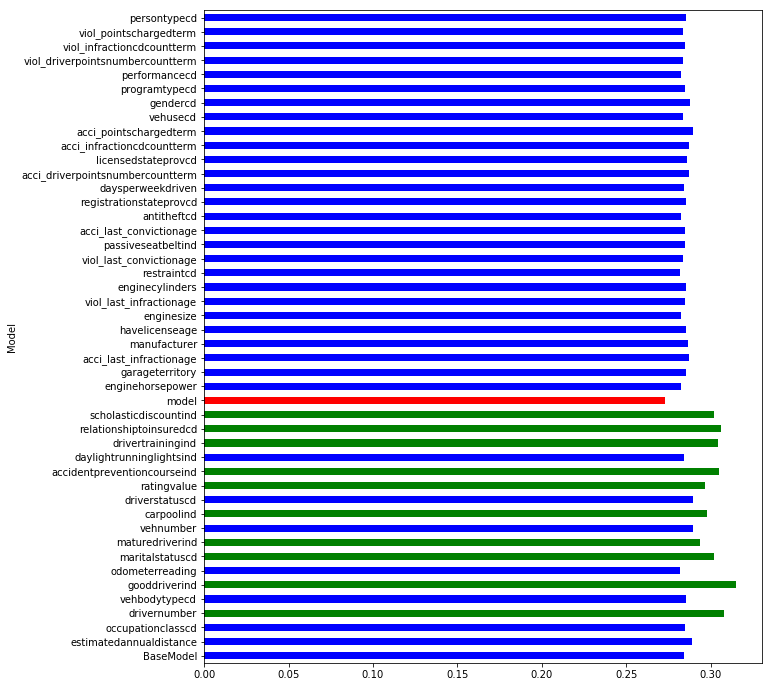

In [103]:
customcmap = tuple(models_test_gini_df['Group'].map(colors))
models_test_gini_df['Mean'].plot(kind='barh',  color=[customcmap], figsize=(10, 12))